In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing the necessary packages

In [ ]:
!pip install tensorflow --quiet
!pip install tensorflow-text --quiet
!pip install tensorflow_hub --quiet
!pip install matplotlib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 133.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 44.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
# import seaborn as sns
import pandas
# import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
import keras

Importing the bert base model for sentence vectorization and the necessary pre-processor for it from tensorflow hub

In [ ]:
text_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
df = pandas.read_csv('/content/drive/MyDrive/train.csv')

droping rows with empty valuse in the columns of DESCRIPTION and BULLET_POINTS

In [ ]:
df = df.dropna(subset=['DESCRIPTION', 'BULLET_POINTS'])
target = df.pop("PRODUCT_LENGTH")

Removing the extra and unecessary characters in "BULLET POINTS"

In [ ]:
t = len(df)
df["BULLET_POINTS"] = df["BULLET_POINTS"].str.replace('|', '', regex=True)
df["BULLET_POINTS"] = df["BULLET_POINTS"].str.replace('\[', '', regex=True)
df["BULLET_POINTS"] = df["BULLET_POINTS"].str.replace('\]', '', regex=True)
print(t)

1038460


constricting the feature set to just three features

In [ ]:
df = df[["TITLE", "DESCRIPTION","BULLET_POINTS", "PRODUCT_TYPE_ID"]]
df.head()

,TITLE,DESCRIPTION,BULLET_POINTS,PRODUCT_TYPE_ID
2,PRIKNIK Horn Red Electric Air Horn Compressor ...,"Specifications: Color: Red, Material: Aluminiu...","Loud Dual Tone Trumpet Horn, Compatible With S...",7537
3,ALISHAH Women's Cotton Ankle Length Leggings C...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,Made By 95%cotton and 5% Lycra which gives you...,2996
5,HINS Metal Bucket Shape Plant Pot for Indoor &...,HINS Brings you the most Elegant Looking Pot w...,"Simple and elegant, great for displaying indoo...",5725
7,Delavala Self Adhesive Kitchen Backsplash Wall...,<p><strong>Aluminum Foil Stickers-good kitchen...,HIGH QUALITY PVC MATERIAL: The kitchen aluminu...,6030
9,Hexwell Essential oil for Home Fragrance Oil A...,"Transform your home, workplace or hotel room i...",100% Pure And Natural Essential Oil Or Fragran...,8201


In [ ]:
ds = tf.convert_to_tensor(df["BULLET_POINTS"])

Defining the Inputs

In [ ]:
inputs = {}
for name, column in df.items():
  if type(column.iloc[0]) == str:                                     # checking if the data type is string or numerical
    dtype=tf.string                                                   # if string then set the dtype to tensorflow string
    inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)
  else:
    dtype = tf.int64                                                  # else set dtype to tensorflow 64 bit integer
    inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

In [ ]:
inputs # created a virtual input or like the input configuration

{'TITLE': <KerasTensor: shape=(None,) dtype=string (created by layer 'TITLE')>,
 'DESCRIPTION': <KerasTensor: shape=(None,) dtype=string (created by layer 'DESCRIPTION')>,
 'BULLET_POINTS': <KerasTensor: shape=(None,) dtype=string (created by layer 'BULLET_POINTS')>,
 'PRODUCT_TYPE_ID': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'PRODUCT_TYPE_ID')>}

Creating a preprocessor

In [ ]:
preprocessed = []
vocab = sorted(set(df["PRODUCT_TYPE_ID"]))
lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')   # creating a one_hot encoding for the feature PRODUCT_TYPE_ID
x = inputs["PRODUCT_TYPE_ID"][:, tf.newaxis]
x = lookup(x)
preprocessed.append(x)
for name in ["BULLET_POINTS", "TITLE", "DESCRIPTION"]:                            # iterating through textual features and converting the text to vectors by passing them through bert
  x = inputs[name]
  x = text_preprocessor(x)
  x = encoder(x)
  preprocessed.append(x["pooled_output"])


In [ ]:
preprocessed                                                                      # created a virtual output of the preprocessor

[<KerasTensor: shape=(None, 11122) dtype=float32 (created by layer 'integer_lookup')>,
 <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer_1')>,
 <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer_1')>,
 <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer_1')>]

In [ ]:
preprocessed_result = tf.concat(preprocessed, axis=-1)                            # mixing all the inputs into a single tensor
preprocessed_result

<KerasTensor: shape=(None, 13426) dtype=float32 (created by layer 'tf.concat_1')>

In [ ]:
preprocessor = tf.keras.Model(inputs, preprocessed_result)                        # initializing a preprocessor from the inputs and outputs

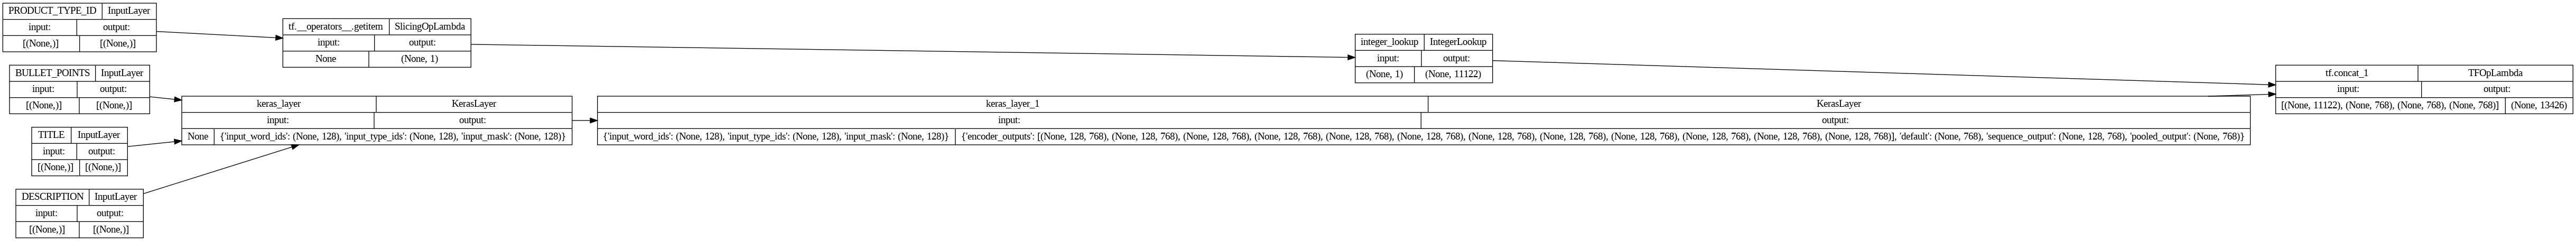

In [ ]:
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

In [ ]:
preprocessor(dict(df.iloc[:1]))

<tf.Tensor: shape=(1, 13426), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        , ..., -0.95147604,
        -0.6242407 ,  0.65334404]], dtype=float32)>

The Dense Network

In [ ]:
body = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

In [ ]:
inputs

{'TITLE': <KerasTensor: shape=(None,) dtype=string (created by layer 'TITLE')>,
 'DESCRIPTION': <KerasTensor: shape=(None,) dtype=string (created by layer 'DESCRIPTION')>,
 'BULLET_POINTS': <KerasTensor: shape=(None,) dtype=string (created by layer 'BULLET_POINTS')>,
 'PRODUCT_TYPE_ID': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'PRODUCT_TYPE_ID')>}

In [ ]:
x = preprocessor(inputs)
x

<KerasTensor: shape=(None, 13426) dtype=float32 (created by layer 'model_2')>

In [ ]:
result = body(x)
result                                                                            # definition of the final output of the model

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential_8')>

Final Model

In [ ]:
model = tf.keras.Model(inputs, result)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

In [ ]:
history = model.fit(dict(df), target, epochs=5, batch_size=8)

Epoch 1/5
  1805/129808 [..............................] - ETA: 438:48:38 - loss: 2721839616.0000 - accuracy: 0.0015